# Running GROMACS on AQE for Polymer Simulation

This notebook will demonstrate the pipeline of calculating glass transition temperature $(T_g)$ using GROMACS molecular dynamics software.

- [x] We need to load an AiiDA profile. The `load_profile` method will load the default profile if no explicit profile name is specified.

In [4]:
from aiida import load_profile
load_profile()

Profile<uuid='854b62c634cd4cd6ade4c630f3c0af0e' name='gromacs'>

#Delete this shell. (No USE -- )
%aiida
%verdi status

We need to set some user defined parameters which will be used throughout the pipeline

In [5]:
# Polymer/Monomer inputs
# monomer_pdbfilename = ''                        # PDB filename of the monomer
# monomer_count_per_polymer = 50                  # Number of monomers present in one polymer
polymer_pdbfilename = '14tPBSingleChain.pdb'    # PDB filename of the polymer
polymer_count = 50                              # Number of polymer in the simulation box

# MD simulation inputs
thermo_T = 300.15                               # Simulation Temperature (K)
thermo_P = 1.0      
# Simulation Pressure (bar)

Two types of input data is required from the user.
1. Polymer input/Monomoer input - User will provide the name of the polymer and the number of polymers they want to use in molecular dynamics simulation inorder to optimize the computational cost with highest efficacy.
(**_NOTE:_** Once the polymerization step is introduced, the polymer input will be replaced by the monomer inputs.)

2. MD simulation inputs - User will provide an absolute thermodynamic condition for the simulation (i.e. temperature and pressure) or a range of temperature and pressure at which simulation will be conducted.

**_NOTE:_** A minimum intervention will be required after this.

Necessary python packages are imported.

In [7]:
import pathlib
import os

from aiida import engine, orm
from aiida_shell import launch_shell_job

We are opening the folder adn wrap it in AiiDA's `FolderData` data type, which allows it to be stored in the provenance graph.

This default values will remain same everywhere.

In [8]:
# Default Parameters
ffdir = os.getcwd() + '/oplsaa.ff'
oplsaa = orm.FolderData(tree=ffdir)

- [ ] Polymerization step

We are opening the file and wrap it in AiiDA's `SinglefileData` data type, which allows it to be stored in the provenance graph.

In [9]:
polymer = orm.SinglefileData(os.getcwd() + '/' + polymer_pdbfilename)

The `gmx pdb2gmx` is the first GROMACS command to create th topology file according to the forcefield information for the polymer.

In [10]:
# Run `gmx pdb2gmx` to convert the PDB to GROMACS .gro format.
results_pdb2gmx, node_pdb2gmx = launch_shell_job(
    'gmx',
    arguments='pdb2gmx -f {polymer} -o output.gro -water spce -ff oplsaa',
    nodes={
        'polymer': polymer,
        'folder': oplsaa,
    },
    filenames={
        'folder': 'oplsaa.ff'
    },
    outputs=['output.gro', 'topol.top', 'posre.itp'],
    metadata={'options': {'redirect_stderr': True}},
)
#print(results_pdb2gmx['stdout'].get_content())

<div class="alert alert-info">
`gmx` is the GROMACS executable which will be executed with several parameters. The `nodes` argument takes a dictionary of `SinglefileData` and `FolderData` which will be copied to the working directory where the `gmx` command is executed. The `oplsaa` in `nodes` are copied to the `oplsaa.ff` folder in the working directory. If the key of the node appears as a placeholder in the `arguments` argument, it is replaced with its filename. 
</div>

The `gmx pdb2gmx` is expected to generate three outputs of interest:
- `output.gro`: `.gro` file of the polymer.
- `topol.top`: The topology file.
- `posre.itp`: The position restraint file included in the topology file.

<div class="alert alert-info">
These output files will be used in the upcoming steps in the pipeline. To capture these output files in the AiiDA's provenance graph, these filenames are declared in the `output` argunent. `aiida-shell` will wrap these output files in a `SinglefileDtata`.
</div>

Similar to the previous steps, GROMACS creates a simulation box where mutiple chains of the polymer will be inserted for the MD simulations. From the previous step, `.gro` file of the single polymer chain is used to replicate the polymer chain inside the simulation box. In the output, we get a simulation box containing `polymer_count` number of polymers.

In [11]:
results_insert, node_insert = launch_shell_job(
    'gmx',
    arguments='insert-molecules -ci {polymer} -o melt.gro -box 7 -nmol 11',
    nodes={
        'polymer': polymer,
    },
    outputs=['melt.gro'],
    metadata={'options': {'redirect_stderr': True}},
)
#print(results_insert['stdout'].get_content())

While running the `pdb2gmx` command we have created the topology for one single polymer chain. However, in the `topol.top` file we have to provide the number of polymer chain present in the simulation box. Therefore, we are updating the number of molecules line from 1 to `polymer_count` using the `sed` command.

In [12]:
results_updatetop, node_updatetop = launch_shell_job(
    'sed',
    arguments='-i "s/Other               1/Other               9/g" {top}',
    nodes={
        'top': results_pdb2gmx['topol_top'],
    },
    outputs=['topol.top'],
    metadata={'options': {'redirect_stderr': True}},
)
#print(results_updatetop['stdout'].get_content())

<div class="alert alert-info">
The output `topol.top` file is declared in the `output` argunent where `aiida-shell` will wrap these output files in a `SinglefileDtata`.
</div>

**Prerequisite for MD simulations and simulation box preparation is completed and we can proceed to run the molecular dynamics simulation.**

In [13]:
em_mdp = orm.SinglefileData.from_string(
    """
    integrator      = steep
    emtol           = 1000.0
    emstep          = 0.01
    nsteps          = 50000
    nstlist         = 1
    cutoff-scheme   = Verlet
    ns_type         = grid
    coulombtype     = PME
    rcoulomb        = 1.0
    rvdw            = 1.0
    pbc             = xyz
    ld_seed         = 1
    gen_seed        = 1
    """,
    filename='em.mdp',
)

# Run `gmx grompp` to pre-process the parameters for energy minimization.
results_grompp_em, node_grompp_em = launch_shell_job(
    'gmx',
    arguments='grompp -f {mdp} -c {gro} -p {top} -o output.tpr',
    nodes={
        'mdp': em_mdp,
        'gro': results_insert['melt_gro'],
        'top': results_updatetop['topol_top'],
        'folder': oplsaa,
    },
    filenames={
        'folder': 'oplsaa.ff'
    },
    outputs=['output.tpr'],
    metadata={'options': {'redirect_stderr': True}},
)
#print(results_grompp_em['stdout'].get_content())

The `gmx grompp` takes the input of three necesary files to generate the `.tpr` file.
- [x] `.mdp`: The molecular dynamics parameters.
- [x] `.gro`: The coordinate information of all the polymer chains present in the simulation box.
- [x] `.top`: The tolology file of the polymer. Also, this has the information of number of polymers present in the simulation box.

The generated `.tpr` file is used for running the molecular dynamics simulation. We can run the `gmx mdrun` to run the energy minimization step.

In [14]:
# Run `gmx mdrun` to run the energy minimization.
results_em, node_em = launch_shell_job(
    'gmx',
    arguments='mdrun -v -deffnm output -s {tpr}',
    nodes={
        'tpr': results_grompp_em['output_tpr'],
    },
    outputs=['output.edr', 'output.gro', 'output.log'],
    metadata={'options': {'redirect_stderr': True}},
)
#print(results_em['stdout'].get_content())

Similar to the previous `gmx grompp` step, we can proceed with NPT equilibration step where the molecular dynamics simulation will be performed at the given thermodynamic conditions given by the user.

In [15]:
eqnpt_mdp = orm.SinglefileData.from_string(
    """
    title                   = NPT Equilibration
    ;define                 = -DPOSRES
    integrator              = md
    dt                      = 0.002
    nsteps                  = 500000
    nstenergy               = 2000
    nstxout-compressed      = 10000
    nstvout                 = 0
    nstlog                  = 1000
    gen_vel                 = yes
    gen_temp                = 298.15
    pbc                     = xyz
    cutoff-scheme           = Verlet
    rlist                   = 1.0
    ns_type                 = grid
    nstlist                 = 10
    coulombtype             = PME
    fourierspacing          = 0.12
    pme_order               = 4
    rcoulomb                = 1.0
    vdwtype                 = Cut-Off
    rvdw                    = 1.0
    DispCorr                = EnerPres
    constraints             = h-bonds
    constraint_algorithm    = lincs
    lincs_iter              = 1
    lincs_order             = 4
    tcoupl                  = v-rescale
    tc-grps                 = System
    ref_t                   = 298.15
    tau_t                   = 0.1
    pcoupl                  = c-rescale
    pcoupltype              = isotropic
    ref_p                   = 1.0
    tau_p                   = 2.0
    ;refcoord-scaling        = com
    compressibility         = 4.5e-5
    """,
    filename='eqnpt.mdp',
)

# Run `gmx grompp` to pre-process the parameters for energy minimization.
results_grompp_eqnpt, node_grompp_eqnpt = launch_shell_job(
    'gmx',
    arguments='grompp -f {mdp} -c {gro} -p {top} -o npt.tpr',
    nodes={
        'mdp': eqnpt_mdp,
        'gro': results_em['output_gro'],
        'top': results_updatetop['topol_top'],
        'folder': oplsaa,
    },
    filenames={
        'folder': 'oplsaa.ff'
    },
    outputs=['npt.tpr'],
    metadata={'options': {'redirect_stderr': True}},
)
#print(results_grompp_eqnpt['stdout'].get_content())

The generated `.tpr` file is used for running the molecular dynamics simulation for NPT equilibration. We can run the `gmx mdrun` to run the NPT equilibration step.

In [16]:
# Run `gmx mdrun` to run the energy minimization.
results_eqnpt, node_eqnpt = launch_shell_job(
    'gmx',
    arguments='mdrun -v -deffnm output -s {tpr}',
    nodes={
        'tpr': results_grompp_eqnpt['npt_tpr'],
    },
    outputs=['output.edr', 'output.gro', 'output.log', 'output.xtc'],
    metadata={'options': {'redirect_stderr': True}},
)
#print(results_eqnpt['stdout'].get_content())

**MD simulation is completed. Therefore, we can go for analysis of the simulated system.**

<div class="alert alert-info">
Using `gmx energy` command we can calculate and plot the primary properties for the simulated polymer system.
</div>

In [17]:
# Run `gmx energy` to extract the potential energy during the energy minimization.
results_energy, node_energy = launch_shell_job(
    'gmx',
    arguments='energy -f {edr} -o potential.xvg',
    nodes={
        'edr': results_eqnpt['output_edr'],
        'stdin': orm.SinglefileData.from_string('10\n0'),
    },
    outputs=['potential.xvg'],
    metadata={'options': {'redirect_stderr': True, 'filename_stdin': 'stdin'}},
)

<div class="alert alert-info">
The input for `gmx energy` is the `output.edr` from the `results_eqnpt`. Here we first pass `10` which corresponds to the potential energy, followed by `0` which finalizes the selection and completes the prompt. The `output` file of this step saved as GROMACS generated `.xvg` format.
</div>

To visualize the data, first we need to import necessary python packages to be installed.

In [18]:
import io

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display, IFrame

We define the `create_plot` function and pass the `potential.xvg` from the previous step. The `create_plot` will create a plot which is saved to a stream in memory which is then passed to a `SinglefileData` node to store it in AiiDA's provecance graph.

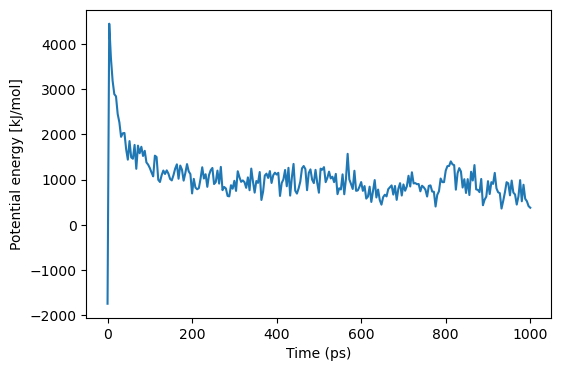

In [19]:
#@engine.calcfunction
def create_plot(xvg: orm.SinglefileData) -> orm.SinglefileData:
    """Plot the data of a XVG output file."""
    lines = xvg.get_content().split('\n')
    data = np.loadtxt(lines, comments=['#', '@']).T
    plt.figure(figsize=(6,4))
    plt.plot(*data)
    plt.xlabel('Time (ps)')
    plt.ylabel('Potential energy [kJ/mol]')
    stream = io.BytesIO()
    plt.savefig(stream, format='png', bbox_inches='tight', dpi=150)
    #stream.seek(0)
    return orm.SinglefileData(stream, filename='potential.png')
    
# Create a plot from the extracted potential energy of the system
plot = create_plot(results_energy['potential_xvg'])

In the same way we can get the density data from the `output.edr` using the `gmx energy` command and plot it.

In [20]:
# Run `gmx energy` to extract the potential energy during the energy minimization.
results_energy, node_energy = launch_shell_job(
    'gmx',
    arguments='energy -f {edr} -o density.xvg',
    nodes={
        'edr': results_eqnpt['output_edr'],
        'stdin': orm.SinglefileData.from_string('22\n0'),
    },
    outputs=['density.xvg'],
    metadata={'options': {'redirect_stderr': True, 'filename_stdin': 'stdin'}},
)

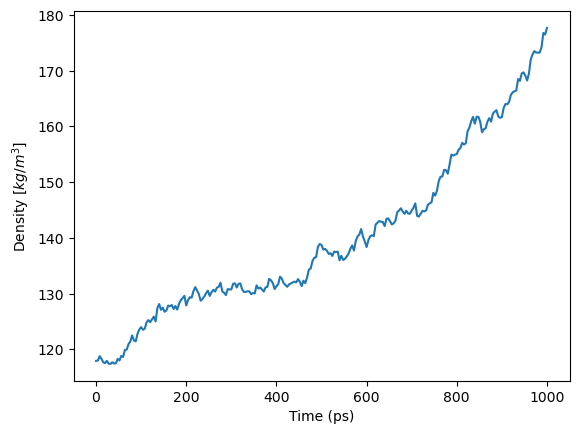

In [21]:
#@engine.calcfunction
def create_plot(xvg: orm.SinglefileData) -> orm.SinglefileData:
    """Plot the data of a XVG output file."""
    lines = xvg.get_content().split('\n')
    data = np.loadtxt(lines, comments=['#', '@']).T
    plt.plot(*data)
    plt.xlabel('Time (ps)')
    plt.ylabel('Density $[kg/m^3]$')
    stream = io.BytesIO()
    plt.savefig(stream, format='png', bbox_inches='tight', dpi=300)
    #stream.seek(0)
    return orm.SinglefileData(stream, filename='density.png')

# Create a plot from the extracted density of the system
plot = create_plot(results_energy['density_xvg'])